In [ ]:
!unzip modelos_balance_accuracy.zip

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import pickle
import statistics as stat
import os
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# Install HiClass
!pip install hiclass==3.1.5 memory_profiler

In [ ]:
path_csv_features = 'data/'
preprocess_method = 'comert'
features = pd.read_csv(path_csv_features+preprocess_method+'_gaps_features.csv', index_col=0)
path_csv_clinical = 'data/'
clinical_df = pd.read_csv(path_csv_clinical+'clinical_ctu-chb.csv', index_col=0, compression='gzip')
df = features
# y is 1 if ill, 0 if healthy
conditions = [clinical_df['apgar1'] <= 6,
              (clinical_df['apgar1'] > 6) & (clinical_df['apgar1'] <= 8),
              clinical_df['apgar1'] > 8]
 
choices = [1,2,3]
 
df['y1'] = np.select(conditions, choices)
df['y2'] = np.where(clinical_df['ph'] < 7.2, 1, 0)
df = df.dropna()
df = df.loc[:, df.columns != 'SampEn015']
df = df.loc[:, df.columns != 'SampEn020']
df['apgar1'] = clinical_df['apgar1']
# normalize df
df_normalized=(df-df.mean())/df.std()

y = df[["y1", "y2"]]
X1 = df_normalized[['baseline', 'DCC', 'ACC', 'mean', 'std', 'LTV', 'delta', 'STV', 'II']]
X2 = df_normalized[['baseline', 'DCC', 'ACC', 'mean', 'std', 'LTV', 'delta', 'STV', 'II', 'ApEn015', 'ApEn020', 'LZC']]
X3 = df_normalized[df_normalized.columns.difference(['apgar1', 'y', 'y1', 'y2'])]

In [ ]:
df[df['apgar1'] == 1]

,baseline,DCC,ACC,mean,std,LTV,delta,STV,II,ApEn015,...,energy MF,homogeneity MF,contrast HF,correlation HF,energy HF,homogeneity HF,y1,y2,apgar1,class
1065,99.280783,5,9,105.230432,27.973182,14.406485,86.081858,8.229189,0.306788,0.020369,...,0.551860,0.978517,0.437407,0.987472,0.594022,0.976280,1,1,1,Bajo
1361,91.019696,4,4,95.970312,31.772427,13.662823,36.428000,2.957168,0.093331,0.061867,...,0.779564,0.992708,0.431265,0.987956,0.698649,0.988955,1,1,1,Bajo


## Hierarchical Method

In [ ]:
import itertools
from hiclass import LocalClassifierPerParentNode

In [ ]:
def classifier2(X, y, pipeline, param_grid, base_route, iterations=100, scoring='balanced_accuracy'):
    scorings=[]
    best_params = {}
    for key in param_grid:
        best_params[key] = []


    grid = []
    for key, l in param_grid.items():
        content = []
        for val in l:
            content.append({key: val})
        grid.append(content)

    param_grid = [{k: v for d in item for k, v in d.items()} for item in itertools.product(*grid)]
    
    for it in range(iterations):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y['y2'], random_state=it)
        
        hierarchical_route = base_route+str(it)+'.pkl'
        # if we already have the hierarchical classifier trained just load it
        if os.path.isfile(hierarchical_route):
            best_model = pickle.load(open(hierarchical_route, 'rb'))
            
        # else, do a cross-validation over the leaf classes (healthy or pathological) to choose the best params for the
        # hierarchical underlying model.
        else:
            # if the method is non-parametric, then just initiate the model
            if not param_grid:
                best_model = LocalClassifierPerParentNode(
                            local_classifier=pipeline,
                            verbose=0,
                            n_jobs=1,
                        )
                
            # if the method is parametric, then do a cross validation to do hyperparameter tuning
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
                potential_models = [[0, None] for _ in range(len(param_grid))]

                for train_index, validate_index in skf.split(X_train, y_train['y2']):
                    X_subtrain, X_validate = X_train.iloc[train_index], X_train.iloc[validate_index]
                    y_subtrain, y_validate = y_train.iloc[train_index], y_train.iloc[validate_index]

                    for i, params in enumerate(param_grid):
                        lcpn = LocalClassifierPerParentNode(
                            local_classifier=pipeline.set_params(**params),
                            verbose=0,
                            n_jobs=1,
                        )

                        lcpn = lcpn.fit(X_subtrain, y_subtrain)
                        predictions = [int(x[1]) for x in lcpn.predict(X_validate)]
                        potential_models[i][0] += balanced_accuracy_score(y_validate['y2'], predictions)
                        potential_models[i][1] = params

                best_params = max(potential_models,key=lambda item:item[0])[1]
                best_model = LocalClassifierPerParentNode(
                    local_classifier=pipeline.set_params(**best_params),
                    verbose=0,
                    n_jobs=1,
                )

            # once the best model is chosen, train it with the entire training set and save it to a local file
            best_model.fit(X_train, y_train)
            pickle.dump(best_model, open(hierarchical_route, 'wb'))

        # get the prediction between healthy or pathological from the hierarchical classifier
        predictions = [int(y[1]) for y in best_model.predict(X_test)]
        scorings.append(balanced_accuracy_score(y_test['y2'], predictions))
            
    return scorings, best_params

### LDA

In [ ]:
pipeline = LinearDiscriminantAnalysis()
param_grid = {}
base_route = 'modelos/hierarchical/method2/base_features/lda/'

scorings, best_params = classifier2(X1, y, pipeline, param_grid, base_route)
mean_base_lda = stat.mean(scorings)
std_base_lda = stat.stdev(scorings)

print("Resultados con features base: " + "%.3f" % mean_base_lda + ' +/- ' + "%.3f" % std_base_lda)


base_route = 'modelos/hierarchical/method2/mid_features/lda/'
scorings, best_params = classifier2(X2, y, pipeline, param_grid, base_route)
mean_mid_lda = stat.mean(scorings)
std_mid_lda = stat.stdev(scorings)

print("Resultados con features intermedias: " + "%.3f" % mean_mid_lda + ' +/- ' + "%.3f" % std_mid_lda)


base_route = 'modelos/hierarchical/method2/all_features/lda/'
scorings, best_params = classifier2(X3, y, pipeline, param_grid, base_route)
mean_all_lda = stat.mean(scorings)
std_all_lda = stat.stdev(scorings)

print("Resultados con todas las features: " + "%.3f" % mean_all_lda + ' +/- ' + "%.3f" % std_all_lda)

Resultados con features base: 0.595 +/- 0.037
Resultados con features intermedias: 0.592 +/- 0.037
Resultados con todas las features: 0.598 +/- 0.038


### QDA

In [ ]:
pipeline = QuadraticDiscriminantAnalysis()
param_grid = {}
base_route = 'modelos/hierarchical/method2/base_features/qda/'

scorings, best_params = classifier2(X1, y, pipeline, param_grid, base_route)
mean_base_qda = stat.mean(scorings)
std_base_qda = stat.stdev(scorings)

print("Resultados con features base: " + "%.3f" % mean_base_qda + ' +/- ' + "%.3f" % std_base_qda)


base_route = 'modelos/hierarchical/method2/mid_features/qda/'
scorings, best_params = classifier2(X2, y, pipeline, param_grid, base_route)
mean_mid_qda = stat.mean(scorings)
std_mid_qda = stat.stdev(scorings)

print("Resultados con features intermedias: " + "%.3f" % mean_mid_qda + ' +/- ' + "%.3f" % std_mid_qda)


base_route = 'modelos/hierarchical/method2/all_features/qda/'
scorings, best_params = classifier2(X3, y, pipeline, param_grid, base_route)
mean_all_qda = stat.mean(scorings)
std_all_qda = stat.stdev(scorings)

print("Resultados con todas las features: " + "%.3f" % mean_all_qda + ' +/- ' + "%.3f" % std_all_qda)

Resultados con features base: 0.591 +/- 0.039
Resultados con features intermedias: 0.589 +/- 0.042
Resultados con todas las features: 0.559 +/- 0.035


### LOGREG

In [ ]:
pipeline = LogisticRegression()
solvers = ['liblinear', 'sag', 'newton-cg', 'lbfgs']
c_values = [0.01, 0.05, 0.1, 0.5, 1, 1.5, 5, 10, 100, 1000]
param_grid = {'solver': solvers, 'C': c_values}

base_route = 'modelos/hierarchical/method2/base_features/logreg/'

scorings, best_params = classifier2(X1, y, pipeline, param_grid, base_route)
mean_base_logreg = stat.mean(scorings)
std_base_logreg = stat.stdev(scorings)

print("Resultados con features base: " + "%.3f" % mean_base_logreg + ' +/- ' + "%.3f" % std_base_logreg)


base_route = 'modelos/hierarchical/method2/mid_features/logreg/'
scorings, best_params = classifier2(X2, y, pipeline, param_grid, base_route)
mean_mid_logreg = stat.mean(scorings)
std_mid_logreg = stat.stdev(scorings)

print("Resultados con features intermedias: " + "%.3f" % mean_mid_logreg + ' +/- ' + "%.3f" % std_mid_logreg)


base_route = 'modelos/hierarchical/method2/all_features/logreg/'
scorings, best_params = classifier2(X3, y, pipeline, param_grid, base_route)
mean_all_logreg = stat.mean(scorings)
std_all_logreg = stat.stdev(scorings)

print("Resultados con todas las features: " + "%.3f" % mean_all_logreg + ' +/- ' + "%.3f" % std_all_logreg)
#!zip -r /content/modelos_total.zip /content/modelos/
#from google.colab import files
#files.download("/content/modelos_total.zip")

Resultados con features base: 0.595 +/- 0.035
Resultados con features intermedias: 0.589 +/- 0.037
Resultados con todas las features: 0.595 +/- 0.039


### KNN

In [ ]:
pipeline = KNeighborsClassifier()
param_grid = {'leaf_size': list(range(20,40)),
'n_neighbors': list(range(1,30,2)),
'p': [1, 2]}

base_route = 'modelos/hierarchical/method2/base_features/knn/'

#scorings, best_params = classifier2(X1, y, pipeline, param_grid, base_route)
#mean_base_knn = stat.mean(scorings)
#std_base_knn = stat.stdev(scorings)

#print("Resultados con features base: " + "%.3f" % mean_base_knn + ' +/- ' + "%.3f" % std_base_knn)


base_route = 'modelos/hierarchical/method2/mid_features/knn/'
#scorings, best_params = classifier2(X2, y, pipeline, param_grid, base_route)
#mean_mid_knn = stat.mean(scorings)
#std_mid_knn = stat.stdev(scorings)

#print("Resultados con features intermedias: " + "%.3f" % mean_mid_knn + ' +/- ' + "%.3f" % std_mid_knn)


base_route = 'modelos/hierarchical/method2/all_features/knn/'
scorings, best_params = classifier2(X3, y, pipeline, param_grid, base_route)
mean_all_knn = stat.mean(scorings)
std_all_knn = stat.stdev(scorings)

print("Resultados con todas las features: " + "%.3f" % mean_all_knn + ' +/- ' + "%.3f" % std_all_knn)

Resultados con todas las features: 0.561 +/- 0.040


## Graphs

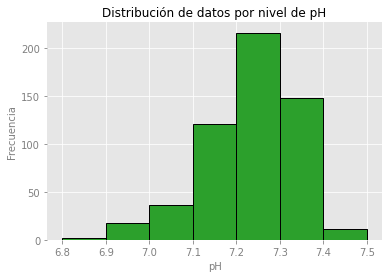

In [ ]:
ax = plt.axes(facecolor='#E6E6E6')
ax.set_axisbelow(True)

plt.hist(clinical_df['ph'], bins=[6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5], color='#2ca02c', edgecolor = "black")
plt.title('Distribución de datos por nivel de pH')
plt.xlabel('pH')
plt.ylabel('Frecuencia')

plt.grid(color='w', linestyle='solid')
for spine in ax.spines.values():
    spine.set_visible(False)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.xaxis.label.set_color('gray')
ax.yaxis.label.set_color('gray')

ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

plt.show()

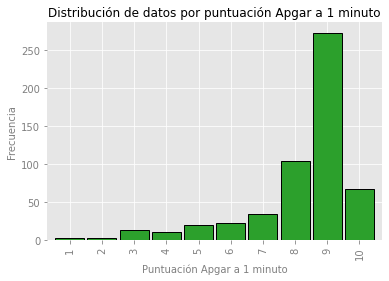

In [ ]:
ax = plt.axes(facecolor='#E6E6E6')
ax.set_axisbelow(True)
df['apgar1'].value_counts().sort_index().plot(ax=ax, kind='bar', xlabel='Puntuación Apgar a 1 minuto', ylabel='Frecuencia', color='#2ca02c', width=0.9, edgecolor = "black")
plt.title('Distribución de datos por puntuación Apgar a 1 minuto')

plt.grid(color='w', linestyle='solid')
for spine in ax.spines.values():
    spine.set_visible(False)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.xaxis.label.set_color('gray')
ax.yaxis.label.set_color('gray')

ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

plt.show()

In [ ]:
df_healthy = df[df['y2'] == 0]['apgar1'].value_counts().sort_index()
df_healthy = df_healthy.rename('healthy')
df_healthy[1] = 0
df_pathological = df[df['y2'] == 1]['apgar1'].value_counts().sort_index()
df_pathological = df_pathological.rename('pathological')

df_total = pd.concat([df_healthy, df_pathological], axis=1)

df_percentage = pd.DataFrame()
df_percentage["healthy"] = df_healthy / (df_healthy + df_pathological)
df_percentage["pathological"] = df_pathological / (df_healthy + df_pathological)

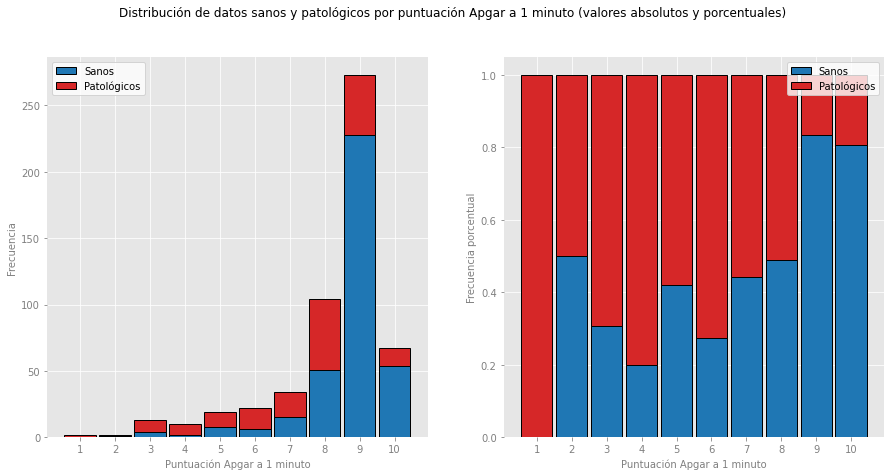

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

fig.suptitle('Distribución de datos sanos y patológicos por puntuación Apgar a 1 minuto (valores absolutos y porcentuales)')

ax1.bar(df_total.index, df_total['healthy'], label='Sanos', zorder=3, width=0.9, edgecolor = "black")
ax1.bar(df_total.index, df_total['pathological'], bottom=df_total['healthy'], color='#d62728', label='Patológicos', zorder=3, width=0.9, edgecolor = "black")
ax1.legend();
ax1.set_xlabel("Puntuación Apgar a 1 minuto")
ax1.set_xticks(df_total.index)
ax1.set_ylabel("Frecuencia")

ax2.bar(df_percentage.index, df_percentage['healthy'], label='Sanos', zorder=3, width=0.9, edgecolor = "black")
ax2.bar(df_percentage.index, df_percentage['pathological'], bottom=df_percentage['healthy'], color='#d62728', label='Patológicos', zorder=3, width=0.9, edgecolor = "black")
ax2.legend();
ax2.set_xlabel("Puntuación Apgar a 1 minuto")
ax2.set_ylabel("Frecuencia porcentual")
ax2.set_xticks(df_percentage.index)


ax1.set_facecolor('#E6E6E6')
ax2.set_facecolor('#E6E6E6')
ax1.grid(color='w', linestyle='solid', zorder=0)
ax2.grid(color='w', linestyle='solid', zorder=0)
for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)

ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()

ax1.xaxis.label.set_color('gray')
ax1.yaxis.label.set_color('gray')
ax2.xaxis.label.set_color('gray')
ax2.yaxis.label.set_color('gray')

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')

for tick in ax1.get_xticklabels():
    tick.set_color('gray')
for tick in ax1.get_yticklabels():
    tick.set_color('gray')
for tick in ax2.get_xticklabels():
    tick.set_color('gray')
for tick in ax2.get_yticklabels():
    tick.set_color('gray')


fig.show()

In [ ]:
conditions = [df['apgar1'] <= 6,
              (df['apgar1'] > 6) & (df['apgar1'] <= 8),
              df['apgar1'] > 8]
 
choices = ['Bajo', 'Medio', 'Alto']

df['class'] = np.select(conditions, choices)
df_healthy = df[df['y2'] == 0]['class'].value_counts().sort_index()
df_healthy = df_healthy.rename('healthy')
df_pathological = df[df['y2'] == 1]['class'].value_counts().sort_index()
df_pathological = df_pathological.rename('pathological')

df_total = pd.concat([df_healthy, df_pathological], axis=1)
df_total = df_total.reindex(["Bajo", "Medio", "Alto"])

df_percentage = pd.DataFrame()
df_percentage["healthy"] = df_healthy / (df_healthy + df_pathological)
df_percentage["pathological"] = df_pathological / (df_healthy + df_pathological)
df_percentage = df_percentage.reindex(["Bajo", "Medio", "Alto"])

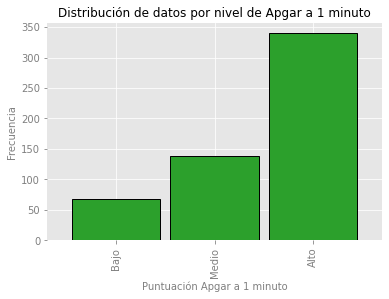

In [ ]:
ax = plt.axes(facecolor='#E6E6E6')
ax.set_axisbelow(True)

plt.title('Distribución de datos por nivel de Apgar a 1 minuto')

custom_dict = {'Bajo': 0, 'Medio': 1, 'Alto': 3} 
df['class'].value_counts().sort_index(key=lambda x: x.map(custom_dict)).plot(ax=ax, kind='bar', xlabel='Puntuación Apgar a 1 minuto', ylabel='Frecuencia', color='#2ca02c', width=0.9, edgecolor = "black")

plt.grid(color='w', linestyle='solid')
for spine in ax.spines.values():
    spine.set_visible(False)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.xaxis.label.set_color('gray')
ax.yaxis.label.set_color('gray')

ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

plt.show()


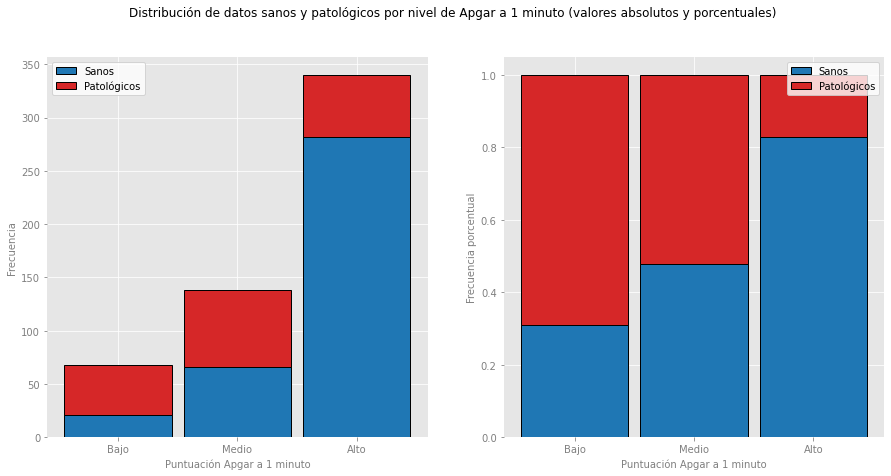

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

fig.suptitle('Distribución de datos sanos y patológicos por nivel de Apgar a 1 minuto (valores absolutos y porcentuales)')

ax1.bar(df_total.index, df_total['healthy'], label='Sanos', zorder=3, width=0.9, edgecolor = "black")
ax1.bar(df_total.index, df_total['pathological'], bottom=df_total['healthy'], color='#d62728', label='Patológicos', zorder=3, width=0.9, edgecolor = "black")
ax1.legend();
ax1.set_xlabel("Puntuación Apgar a 1 minuto")
ax1.set_xticks(df_total.index)
ax1.set_ylabel("Frecuencia")

ax2.bar(df_percentage.index, df_percentage['healthy'], label='Sanos', zorder=3, width=0.9, edgecolor = "black")
ax2.bar(df_percentage.index, df_percentage['pathological'], bottom=df_percentage['healthy'], color='#d62728', label='Patológicos', zorder=3, width=0.9, edgecolor = "black")
ax2.legend();
ax2.set_xlabel("Puntuación Apgar a 1 minuto")
ax2.set_ylabel("Frecuencia porcentual")
ax2.set_xticks(df_percentage.index)


ax1.set_facecolor('#E6E6E6')
ax2.set_facecolor('#E6E6E6')
ax1.grid(color='w', linestyle='solid', zorder=0)
ax2.grid(color='w', linestyle='solid', zorder=0)
for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)

ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()

ax1.xaxis.label.set_color('gray')
ax1.yaxis.label.set_color('gray')
ax2.xaxis.label.set_color('gray')
ax2.yaxis.label.set_color('gray')

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')

for tick in ax1.get_xticklabels():
    tick.set_color('gray')
for tick in ax1.get_yticklabels():
    tick.set_color('gray')
for tick in ax2.get_xticklabels():
    tick.set_color('gray')
for tick in ax2.get_yticklabels():
    tick.set_color('gray')

fig.show()

In [ ]:
def classifier(X, y, pipeline, param_grid, base_route, binary_route, iterations=100, scoring='balanced_accuracy'):
    scorings=[]
    best_params = {}
    for key in param_grid:
        best_params[key] = []
    
    for it in range(iterations):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y['y2'], random_state=it)
        
        hierarchical_route = base_route+str(it)+'.pkl'
        # if we already have the hierarchical classifier trained just load it
        if os.path.isfile(hierarchical_route):
            lcpn = pickle.load(open(hierarchical_route, 'rb'))
            
        # else, do a cross-validation over the leaf classes (healthy or pathological) to choose the best params for the
        # hierarchical underlying model.
        else:
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
            estimator = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, return_train_score=True)
            route = binary_route+str(it)+'.pkl'
            if os.path.isfile(route):
                fitted_model = pickle.load(open(route, 'rb'))
            else:
                fitted_model = estimator.fit(X_train, y_train['y2'])
                pickle.dump(fitted_model, open(route, 'wb'))

            for key in best_params:
                best_params[key].append(fitted_model.best_params_[key])

            # create the hierarchical version of the classifier and train it.
            lcpn = LocalClassifierPerParentNode(
                local_classifier=pipeline.set_params(**fitted_model.best_params_),
                verbose=0,
                n_jobs=1,
            )
            lcpn = lcpn.fit(X_train, y_train)
            pickle.dump(lcpn, open(hierarchical_route, 'wb'))

        # get the prediction between healthy or pathological from the hierarchical classifier
        predictions = [int(x[1]) for x in lcpn.predict(X_test)]
        scorings.append(balanced_accuracy_score(y_test['y2'], predictions))
            
    return scorings, best_params

In [ ]:
from hiclass import LocalClassifierPerParentNode

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
pipeline = LinearDiscriminantAnalysis()
param_grid = {}
base_route = 'modelos/hierarchical/method1/base_features/lda/'
binary_route = 'modelos/binary/balanced_accuracy/base_features/lda/'

scorings, best_params = classifier(X1, y, pipeline, param_grid, base_route, binary_route)
mean_base_lda = stat.mean(scorings)
std_base_lda = stat.stdev(scorings)

print("Resultados con features base: " + "%.3f" % mean_base_lda + ' +/- ' + "%.3f" % std_base_lda)


base_route = 'modelos/hierarchical/method1/mid_features/lda/'
binary_route = 'modelos/binary/balanced_accuracy/mid_features/lda/'
scorings, best_params = classifier(X2, y, pipeline, param_grid, base_route, binary_route)
mean_mid_lda = stat.mean(scorings)
std_mid_lda = stat.stdev(scorings)

print("Resultados con features intermedias: " + "%.3f" % mean_mid_lda + ' +/- ' + "%.3f" % std_mid_lda)


base_route = 'modelos/hierarchical/method1/all_features/lda/'
binary_route = 'modelos/binary/balanced_accuracy/all_features/lda/'
scorings, best_params = classifier(X3, y, pipeline, param_grid, base_route, binary_route)
mean_all_lda = stat.mean(scorings)
std_all_lda = stat.stdev(scorings)

print("Resultados con todas las features: " + "%.3f" % mean_all_lda + ' +/- ' + "%.3f" % std_all_lda)

Resultados con features base: 0.595 +/- 0.037
Resultados con features intermedias: 0.592 +/- 0.037
Resultados con todas las features: 0.598 +/- 0.038


### QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
pipeline = QuadraticDiscriminantAnalysis()
param_grid = {}
base_route = 'modelos/hierarchical/method1/base_features/qda/'
binary_route = 'modelos/binary/balanced_accuracy/base_features/qda/'

scorings, best_params = classifier(X1, y, pipeline, param_grid, base_route, binary_route)
mean_base_qda = stat.mean(scorings)
std_base_qda = stat.stdev(scorings)

print("Resultados con features base: " + "%.3f" % mean_base_qda + ' +/- ' + "%.3f" % std_base_qda)


base_route = 'modelos/hierarchical/method1/mid_features/qda/'
binary_route = 'modelos/binary/balanced_accuracy/mid_features/qda/'
scorings, best_params = classifier(X2, y, pipeline, param_grid, base_route, binary_route)
mean_mid_qda = stat.mean(scorings)
std_mid_qda = stat.stdev(scorings)

print("Resultados con features intermedias: " + "%.3f" % mean_mid_qda + ' +/- ' + "%.3f" % std_mid_qda)


base_route = 'modelos/hierarchical/method1/all_features/qda/'
binary_route = 'modelos/binary/balanced_accuracy/all_features/qda/'
scorings, best_params = classifier(X3, y, pipeline, param_grid, base_route, binary_route)
mean_all_qda = stat.mean(scorings)
std_all_qda = stat.stdev(scorings)

print("Resultados con todas las features: " + "%.3f" % mean_all_qda + ' +/- ' + "%.3f" % std_all_qda)

Resultados con features base: 0.591 +/- 0.039
Resultados con features intermedias: 0.589 +/- 0.042
Resultados con todas las features: 0.559 +/- 0.035


### LOGREG

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
pipeline = LogisticRegression()
solvers = ['liblinear', 'sag', 'newton-cg', 'lbfgs']
c_values = [0.01, 0.05, 0.1, 0.5, 1, 1.5, 5, 10, 100, 1000]
param_grid = {'solver': solvers, 'C': c_values}

base_route = 'modelos/hierarchical/method1/base_features/logreg/'
binary_route = 'modelos/binary/balanced_accuracy/base_features/logreg/'

scorings, best_params = classifier(X1, y, pipeline, param_grid, base_route, binary_route)
mean_base_logreg = stat.mean(scorings)
std_base_logreg = stat.stdev(scorings)

print("Resultados con features base: " + "%.3f" % mean_base_logreg + ' +/- ' + "%.3f" % std_base_logreg)


base_route = 'modelos/hierarchical/method1/mid_features/logreg/'
binary_route = 'modelos/binary/balanced_accuracy/mid_features/logreg/'
scorings, best_params = classifier(X2, y, pipeline, param_grid, base_route, binary_route)
mean_mid_logreg = stat.mean(scorings)
std_mid_logreg = stat.stdev(scorings)

print("Resultados con features intermedias: " + "%.3f" % mean_mid_logreg + ' +/- ' + "%.3f" % std_mid_logreg)


base_route = 'modelos/hierarchical/method1/all_features/logreg/'
binary_route = 'modelos/binary/balanced_accuracy/all_features/logreg/'
scorings, best_params = classifier(X3, y, pipeline, param_grid, base_route, binary_route)
mean_all_logreg = stat.mean(scorings)
std_all_logreg = stat.stdev(scorings)

print("Resultados con todas las features: " + "%.3f" % mean_all_logreg + ' +/- ' + "%.3f" % std_all_logreg)

Resultados con features base: 0.586 +/- 0.031
Resultados con features intermedias: 0.583 +/- 0.035
Resultados con todas las features: 0.582 +/- 0.034


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipeline = KNeighborsClassifier()
param_grid = {'leaf_size': list(range(20,40)),
'n_neighbors': list(range(1,30,2)),
'p': [1, 2]}

base_route = 'modelos/hierarchical/method1/base_features/knn/'
binary_route = 'modelos/binary/balanced_accuracy/base_features/knn/'

scorings, best_params = classifier(X1, y, pipeline, param_grid, base_route, binary_route)
mean_base_knn = stat.mean(scorings)
std_base_knn = stat.stdev(scorings)

print("Resultados con features base: " + "%.3f" % mean_base_knn + ' +/- ' + "%.3f" % std_base_knn)


base_route = 'modelos/hierarchical/method1/mid_features/knn/'
binary_route = 'modelos/binary/balanced_accuracy/mid_features/knn/'
scorings, best_params = classifier(X2, y, pipeline, param_grid, base_route, binary_route)
mean_mid_knn = stat.mean(scorings)
std_mid_knn = stat.stdev(scorings)

print("Resultados con features intermedias: " + "%.3f" % mean_mid_knn + ' +/- ' + "%.3f" % std_mid_knn)


base_route = 'modelos/hierarchical/method1/all_features/knn/'
binary_route = 'modelos/binary/balanced_accuracy/all_features/knn/'
scorings, best_params = classifier(X3, y, pipeline, param_grid, base_route, binary_route)
mean_all_knn = stat.mean(scorings)
std_all_knn = stat.stdev(scorings)

print("Resultados con todas las features: " + "%.3f" % mean_all_knn + ' +/- ' + "%.3f" % std_all_knn)

Resultados con features base: 0.550 +/- 0.036
Resultados con features intermedias: 0.552 +/- 0.038
Resultados con todas las features: 0.554 +/- 0.039


## UTILS

In [ ]:
!rm -rf modelos/hierarchical/method2/*/knn/*

In [ ]:
param_grid = {'leaf_size': list(range(20,40)),
'n_neighbors': list(range(1,30,2)),
'p': [1, 2]}

grid = []

for key, l in param_grid.items():
  content = []
  for val in l:
    content.append({key: val})
  grid.append(content)

a = [{k: v for d in item for k, v in d.items()} for item in itertools.product(*grid)]
print(a)

[{'leaf_size': 20, 'n_neighbors': 1, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 1, 'p': 2}, {'leaf_size': 20, 'n_neighbors': 3, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 3, 'p': 2}, {'leaf_size': 20, 'n_neighbors': 5, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 5, 'p': 2}, {'leaf_size': 20, 'n_neighbors': 7, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 7, 'p': 2}, {'leaf_size': 20, 'n_neighbors': 9, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 9, 'p': 2}, {'leaf_size': 20, 'n_neighbors': 11, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 11, 'p': 2}, {'leaf_size': 20, 'n_neighbors': 13, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 13, 'p': 2}, {'leaf_size': 20, 'n_neighbors': 15, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 15, 'p': 2}, {'leaf_size': 20, 'n_neighbors': 17, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 17, 'p': 2}, {'leaf_size': 20, 'n_neighbors': 19, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 19, 'p': 2}, {'leaf_size': 20, 'n_neighbors': 21, 'p': 1}, {'leaf_size': 20, 'n_neighbors': 21, 'p': 2